## Erdos-Renyi HG Rates

In [1]:
import numpy as np
import matplotlib.pylab as plt
import random
from scipy.special import comb

import sys
sys.path.append('../src/')
from Hypergraphs import EmptyHypergraph
from simulate_gillespie import *
from estimate_total_rates import *

sys.path.append('../scripts/')
from generators_hg import p1_p2_ER_like_uncorrelated_hypergraph, ER_like_random_hypergraph

## Setup

In [ ]:
## --- Setup --- ##
test_name = "random_ER"
g_type = "random_ER"

N = 1000
I0 = 1
nsims = 500
run_gillespie_simulations = True
time_max = 50

max_pw_edges = comb(N, 2, exact=True) # N * (N - 1) / 2
max_ho_edges = comb(N, 3, exact=True) # N * (N - 1) * (N - 2) / 6

k1_k2_list = [(3, 1), (6, 2), (10, 3), (20, 6)]
(k1, k2) = k1_k2_list[2]

p1, p2 = p1_p2_ER_like_uncorrelated_hypergraph(k1,k2,N)
print(f"target p1: {p1:.4f}")
print(f"target p2: {p2:.8f}\n")
print(f"target pw edges: {p1 * max_pw_edges:.0f}/{max_pw_edges:.0f}")
print(f"target ho edges: {p2 * max_ho_edges:.0f}/{max_ho_edges:.0f}\n")

G, edges, triangles = ER_like_random_hypergraph(N,p1,p2)
all_edges = edges.tolist() + triangles.tolist()
g_edges = []
for edge in all_edges:
    g_edges.append(tuple(edge))

g = EmptyHypergraph(N)
g.name = g_type
g.set_edges(g_edges)

p1_est = len(edges) / max_pw_edges
p2_est = len(triangles) / max_ho_edges
print(f"realized p1: {p1_est:.4f}")
print(f"realized p2: {p2_est:.8f}\n")
print(f"realized pw edges:  {len(edges):.0f}/{max_pw_edges:.0f}")
print(f"realized ho edges:  {len(triangles):.0f}/{max_ho_edges:.0f}\n")

# set beta1, beta2 such that k^* = .75 N
mu    = 1             # recovery rate

# lambda_1 \in [0,3]
# lambda_2 \in [0,10]
lambda1 = 1.1
lambda2 = 5.0

beta1 = lambda1 * mu / k1 # pairwise infection rate
beta2 = lambda2 * mu / k2 # hyperedge contagion rate

# g.summary()

print(f"{test_name}: \n")
print(f"\tH = {g.name}, N = {N}, (k1, k2) = {(k1, k2)}, I0 = {I0}, time_max = {time_max},")
g.print()

print(f"\tbeta1 * N = {beta1 * N}, beta2 * N^2 = {beta2 * (N**2):.2f}, mu = {mu},")
print(f"\twith estimation based on {nsims} Gillespie simulation runs\n")

target p1: 0.0100
target p2: 0.00000602

target pw edges: 5000/499500
target ho edges: 1000/166167000

realized p1: 0.0101
realized p2: 0.00000608

realized pw edges:  5043/499500
realized ho edges:  1011/166167000

random_ER: 

	H = random_ER, N = 1000, (k1, k2) = (10, 3), I0 = 1, time_max = 50,
	random_ER on 1000 nodes with 6054 edges.

	beta1 * N = 110.00000000000001, beta2 * N^2 = 1666666.67, mu = 1,
	with estimation based on 500 Gillespie simulation runs



## Run Gillespie

break: total_infected == 0: 0, time=0.29971016888667656
exited on time=50.000540785446965, waiting_time=0.0010910012147526628
break: total_infected == 0: 0, time=0.7773287088761776
break: total_infected == 0: 0, time=2.055863171734384
break: total_infected == 0: 0, time=0.3042149721627017
break: total_infected == 0: 0, time=0.923922842468287
break: total_infected == 0: 0, time=0.09516012420634606
break: total_infected == 0: 0, time=23.959792536121878
break: total_infected == 0: 0, time=2.328998893143408
break: total_infected == 0: 0, time=1.1281836766489928
break: total_infected == 0: 0, time=0.1641547383801435
break: total_infected == 0: 0, time=2.2079427486947605
break: total_infected == 0: 0, time=1.7550918724068816
break: total_infected == 0: 0, time=0.25138302209933333
break: total_infected == 0: 0, time=2.2714945248872254
break: total_infected == 0: 0, time=1.890134129684529
break: total_infected == 0: 0, time=0.6008898328032293
exited on time=50.000329230301396, waiting_time=0.0

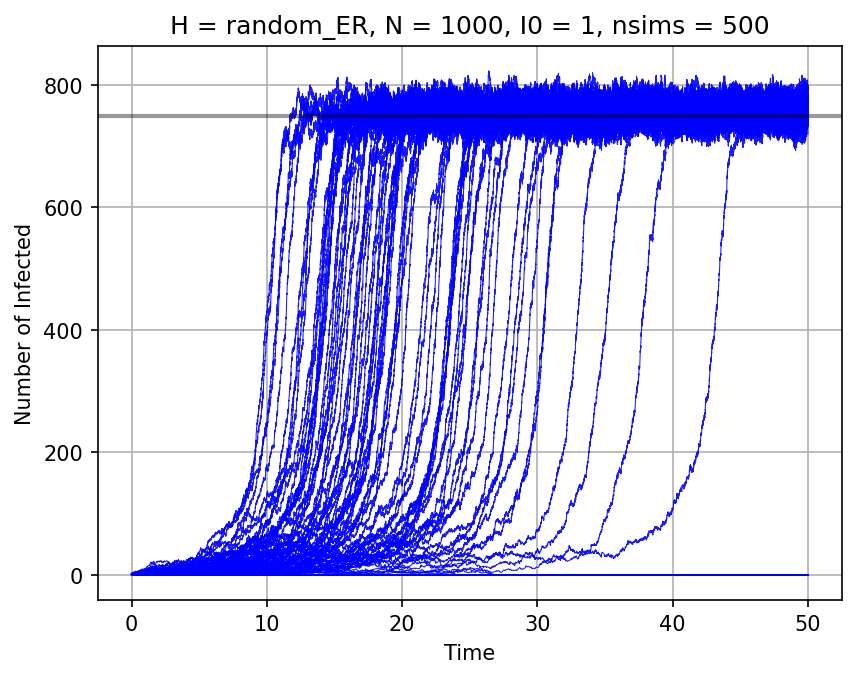

In [3]:
## --- Run Gillespie ---
run_gillespie_simulations = True

I0_gillespie = I0 # TODO: go over the range when necessary
nodes = list(g.nodes.keys())
initial_infections = random.sample(nodes, I0)

if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = gillespie_sim(g, beta1, beta2, mu, initial_infections, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}_HG.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}_HG.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, I0 = {I0}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/{test_name}/gillespie-sims_HG.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

## Burn-in / alignment approach

### Idea:
Once an outbreak takes hold (reaches certain number of infected `k_threshold`), the subsequent dynamics (growth phase to quasi-stationary state) should look similar accross different runs, just shifted in time due to initial very variable initial phase.

### Burn-in / alignment approach:

1. Choose `k_threshold = 0.1 * N` (or a fixed number like 50 or 100)

2. For each simulation run `i` that reaches `k_threshold`, find time `t_i` when it first crosses `k_threshold`

3. Time-shift each such run `i`: `t = t - t_i`, to align the trajectory to the point where outbreak reached `k_threshold`

4. Then average all aligned trajectories, to get an average trajectory

### Similarity to complete graph:
Once critical mass of infection is present, average rate of new infections in well connected E-R graph should behave more like on well-mixed complete graph, influenced by overall density, such that expected $a_k, b_k$ rates are $a_k, b_k$ rates for complete scaled by $p_1, p_2$.

In [4]:
def align_trajectories(X_sims, k_threshold, new_time_max):
    X_sims_aligned = []

    for i, X_t in enumerate(X_sims):
        times_orig = X_t[0, :].astype(float)
        infected_orig = X_t[2, :].astype(int)
        above_threshold_indices = np.where(infected_orig >= k_threshold)[0]
        if len(above_threshold_indices) > 0:
            # outbreak reached the threshold
            start_index = above_threshold_indices[0]
            start_time = times_orig[start_index]

            times_shifted = times_orig[start_index:] - start_time
            end_indices = np.where(times_shifted > new_time_max)[0]

            if len(end_indices) > 0:
                end_index = start_index + end_indices[0]
            else:
                # skip it
                print("Run ended before start_time + new_time_max")
            X_t_aligned = X_t[:, start_index:end_index].copy()

            # update times in X_t to times_shifted
            X_t_aligned[0, :] = times_shifted[:len(X_t_aligned[0,:])]
            X_sims_aligned.append(X_t_aligned)
    
    print(f"Aligned {len(X_sims_aligned)}/{len(X_sims)} trajectories.")
    return X_sims_aligned

In [5]:
k_threshold = 100
new_time_max = 10.0

X_sims_aligned = align_trajectories(X_sims, k_threshold, new_time_max)

Aligned 75/500 trajectories.


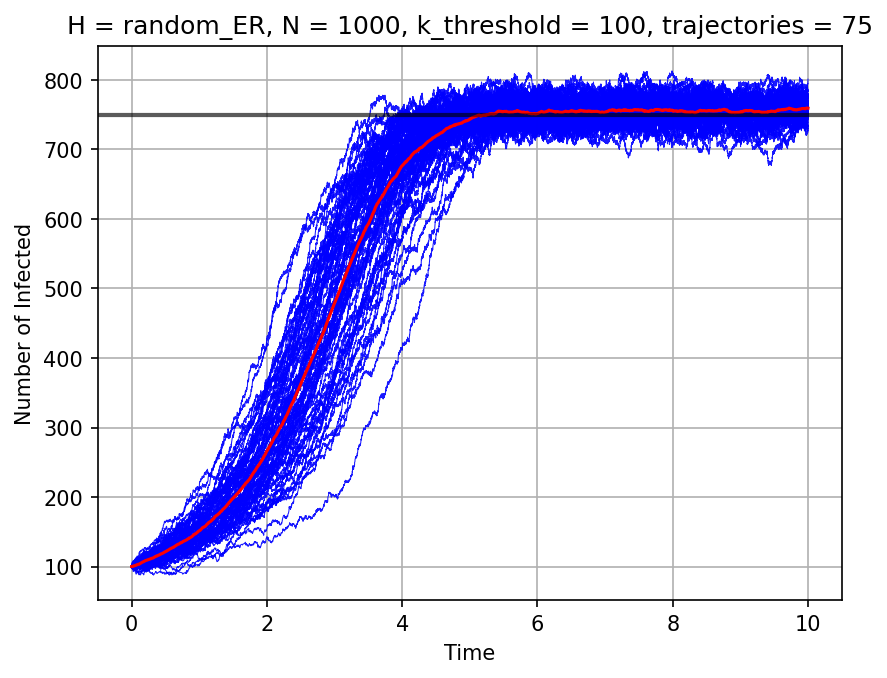

In [6]:
# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims_aligned:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims_aligned, new_time_max, len(X_sims_aligned), delta_t = 0.01)

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.plot(times, avg_curve, "red")

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, k_threshold = {k_threshold}, trajectories = {len(X_sims_aligned)}")
plt.savefig(f"../figures/estimation/{test_name}/gillespie-sims-aligned_HG.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

## Solve KEs and compare

In [7]:
I0 = 100

# solve KEs and compare
all_states = list(range(N + 1))
M = len(all_states)
# ode_system_complete = list_all_ODEs_complete(g, beta1, beta2, mu)
# ode_system_random = list_all_ODEs_random(g, beta1, beta2, mu, p1, p2)
ode_system_random = list_all_ODEs_random(g, beta1, beta2, mu, p1_est, p2_est)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0
# p0

In [8]:
# solve ode_system_random over time
t_span = (0.0, new_time_max)

# times t_i to evaluate in, get saved in sol.t
steps_eval = 202
t_eval = np.linspace(t_span[0], t_span[1], steps_eval)

def f_ode(t, p):
    return ode_system_random(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="LSODA")

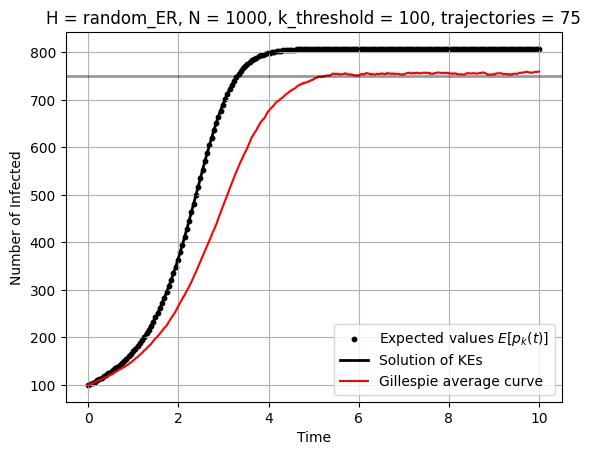

In [9]:
# plot both the expected values of p_{k}(t) 
# and the Gillespie average curve
# on the same figure

expected_values = calculate_expected_values(sol)

plt.figure()
plt.scatter(sol.t, expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.plot(sol.t, expected_values, lw=2, color="k", label="Solution of KEs")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve")

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, k_threshold = {k_threshold}, trajectories = {len(X_sims_aligned)}")
plt.savefig(f"../figures/estimation/{test_name}/solution-vs-gillepsie_HG.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

In [10]:
times

array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ], shape=(1001,))

## Calculate the estimates

In [11]:
## --- Calculate the estimates ---
min_Tk_threshold = 1e-6
estimates = calculate_estimates(X_sims_aligned, N, min_Tk_threshold)

Total events processed: 915842


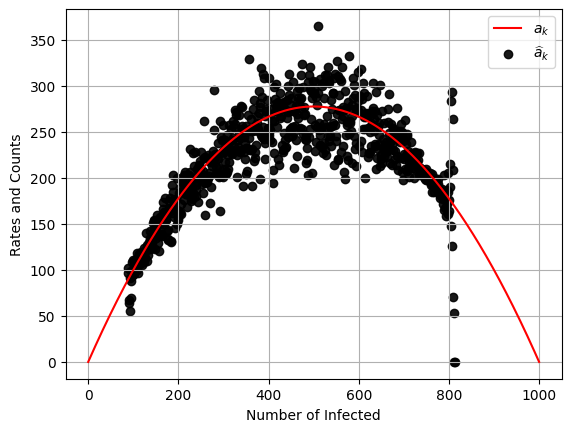

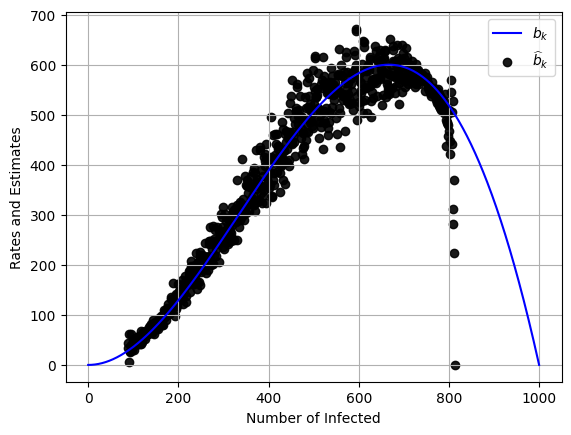

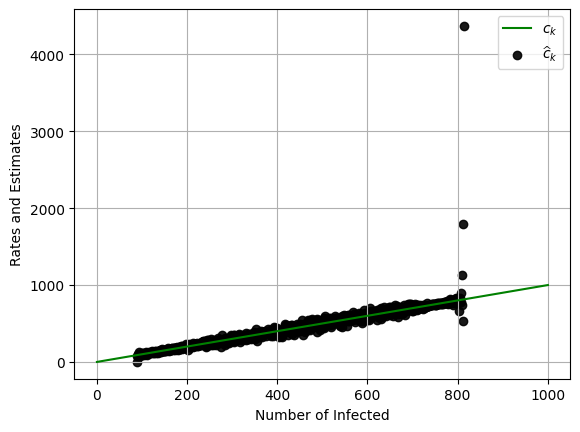

In [ ]:
a_k_hat = estimates["a_k_hat"]
b_k_hat = estimates["b_k_hat"]
c_k_hat = estimates["c_k_hat"]

# plot only where T_k was non-zero!
valid_k_idx = estimates["T_k"] > min_Tk_threshold   

# and compare them to theoretical rates
k_values = np.arange(0, N + 1) # number of infected from 0 to N
k_choose_2 = np.array(list(map(lambda k: comb(k, 2, exact=True), k_values)))

# TODO: what are theoretical rates now?
a_k = p1_est * beta1 * k_values * (N - k_values)
b_k = p2_est * beta2 * k_choose_2 * (N - k_values)
c_k = mu * k_values

fig = plt.figure()
ax = plt.subplot()

# theoretical ak vs. ak hats 
ax.plot(k_values, a_k, label=r'$a_k$', color="red")
ax.scatter(k_values[valid_k_idx], a_k_hat[valid_k_idx],
        label=r'$\widehat{a}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/{test_name}/estimates_ak_HG.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

# theoretical bk vs. bk hats
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, b_k, label=r'$b_k$', color="blue")
ax.scatter(k_values[valid_k_idx], b_k_hat[valid_k_idx],
        label=r'$\widehat{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/{test_name}/estimates_bk_HG.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

# theoretical ck vs. ck hats (as a test only)
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, c_k, label=r'$c_k$', color="green")
ax.scatter(k_values[valid_k_idx], c_k_hat[valid_k_idx],
        label=r'$\widehat{c}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)
plt.savefig(f"../figures/estimation/{test_name}/estimates_ck_HG.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

## Solve KEs using the estimates

In [13]:
## --- Solve KEs using the estimates and compare ---
# --- Model 2 ---
ode_system_complete = list_all_ODEs_using_estimates(g, a_k_hat, b_k_hat, mu)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol_hat = solve_ivp(f_ode, 
                    t_span, 
                    p0, 
                    t_eval=t_eval,
                    method="LSODA")

expected_values_hat = calculate_expected_values(sol_hat)

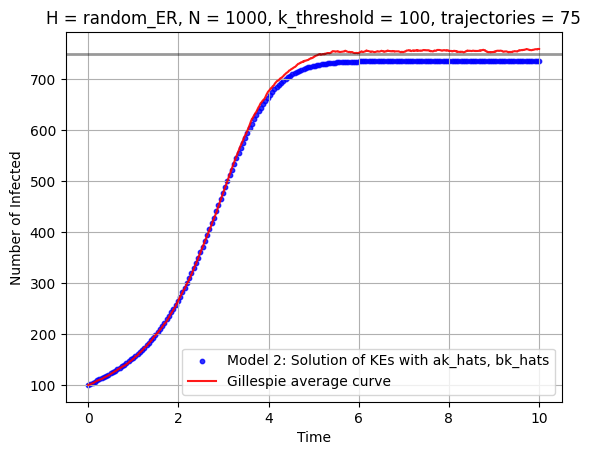

In [14]:
plt.figure()

# plt.plot(sol.t, expected_values_hat, color="b", label="Model 2: Solution of KEs with ak_hats, bk_hats")
plt.scatter(sol.t, expected_values_hat, color="b", s=10, alpha=.8, label="Model 2: Solution of KEs with ak_hats, bk_hats")

plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.9)

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, k_threshold = {k_threshold}, trajectories = {len(X_sims_aligned)}")
plt.savefig(f"../figures/estimation/{test_name}/solutions-comparison_HG.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()